# Проверяем корректность разделения выборки на тестовую и тренировочную

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import itertools
from scipy import linalg
import matplotlib as mpl
from sklearn import mixture
from scipy.stats import norm, multivariate_normal, gaussian_kde, dirichlet, wishart, f, chi2
from scipy.integrate import quad, nquad
from scipy.special import gammaln, psi, digamma, gamma
from scipy.linalg import det, inv
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import rbf_kernel

In [5]:
from dcor import energy_distance

In [7]:
data = pd.read_excel('euro_dollar.xlsx')
data = data.sort_values(by = ['curs_euro'])
data.head()

data = data[data['curs_euro'] > -0.14]

list_of_euro = list(data['curs_euro'])
list_of_dollar = list(data['curs_dollar'])
n_samples = data['curs_euro'].size
n_samples

np_data_dollar = np.array(data['curs_dollar']).reshape(-1, 1)
np_data_euro = np.array(data['curs_euro']).reshape(-1, 1)
np_data_euro

array([[-0.08408749],
       [-0.07404701],
       [-0.0712909 ],
       ...,
       [ 0.10664213],
       [ 0.10718334],
       [ 0.10994489]], shape=(6274, 1))

In [8]:
data_XY = np.concatenate([np_data_euro, np_data_dollar], axis = 1)
data_XY

array([[-0.08408749, -0.07988462],
       [-0.07404701, -0.07152092],
       [-0.0712909 , -0.07147347],
       ...,
       [ 0.10664213,  0.09724502],
       [ 0.10718334,  0.11812002],
       [ 0.10994489,  0.11316388]], shape=(6274, 2))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    np_data_euro, 
    np_data_dollar, 
    test_size=0.2,  # Доля тестовой выборки (можно указать train_size)
    random_state=1,  # Для воспроизводимости
)

XY_train = np.concatenate([X_train, y_train], axis = 1)
XY_test = np.concatenate([X_test, y_test], axis = 1)

n_samples_train = X_train.shape[0]
n_samples_test = X_test.shape[0]

Подходящие seed для разделения

In [19]:
1


1

## Пермутационный подход + энергетическое растояние

In [11]:
def permutation_test(sample1, sample2, n_permutations=1000):
    combined = np.vstack([sample1, sample2])
    obs_stat = energy_distance(sample1, sample2)

    n_x = len(sample1)
    
    perm_stats = []
    for _ in range(n_permutations):
        print('Current permutation:', _)
        np.random.shuffle(combined)
        perm1 = combined[:n_x]
        perm2 = combined[n_x:]
        perm_stat = energy_distance(perm1, perm2)
        perm_stats.append(perm_stat)
    
    p_value = (perm_stats >= obs_stat).mean()
    return p_value

In [12]:
permutation_test(XY_train, XY_test)

Current permutation: 0
Current permutation: 1
Current permutation: 2
Current permutation: 3
Current permutation: 4
Current permutation: 5
Current permutation: 6
Current permutation: 7
Current permutation: 8
Current permutation: 9
Current permutation: 10
Current permutation: 11
Current permutation: 12
Current permutation: 13
Current permutation: 14
Current permutation: 15
Current permutation: 16
Current permutation: 17
Current permutation: 18
Current permutation: 19
Current permutation: 20
Current permutation: 21
Current permutation: 22
Current permutation: 23
Current permutation: 24
Current permutation: 25
Current permutation: 26
Current permutation: 27
Current permutation: 28
Current permutation: 29
Current permutation: 30
Current permutation: 31
Current permutation: 32
Current permutation: 33
Current permutation: 34
Current permutation: 35
Current permutation: 36
Current permutation: 37
Current permutation: 38
Current permutation: 39
Current permutation: 40
Current permutation: 41
Cu

np.float64(0.77)

## Пермутационный подход + Maximum Mean Discrepancy (MMD)

In [13]:
def mmd_rbf(X, Y, gamma=1.0):
    """Вычисляет MMD² между X и Y с гауссовым ядром."""
    K_XX = rbf_kernel(X, X, gamma=gamma)
    K_YY = rbf_kernel(Y, Y, gamma=gamma)
    K_XY = rbf_kernel(X, Y, gamma=gamma)
    
    m = len(X)
    n = len(Y)
    
    mmd = K_XX.mean() + K_YY.mean() - 2 * K_XY.mean()
    return mmd

def mmd_test_with_pvalue(X, Y, gamma=1.0, n_permutations=1000):
    """Пермутационный тест для MMD²."""
    # Наблюдаемое MMD²
    mmd_observed = mmd_rbf(X, Y, gamma=gamma)
    
    # Объединённая выборка
    Z = np.vstack([X, Y])
    n_X = len(X)
    
    # Пермутационный тест
    perm_mmd = []
    for _ in range(n_permutations):
        print('Current permutation:', _)
        np.random.shuffle(Z)  # Перемешиваем
        X_perm = Z[:n_X]      # Первая псевдовыборка
        Y_perm = Z[n_X:]      # Вторая псевдовыборка
        perm_mmd.append(mmd_rbf(X_perm, Y_perm, gamma=gamma))
    
    # Вычисление p-value (с поправкой на устойчивость)
    p_value = (np.sum(perm_mmd >= mmd_observed) + 1) / (n_permutations + 1)
    
    return mmd_observed, p_value

In [14]:
mmd_test_with_pvalue(XY_train, XY_test)

Current permutation: 0
Current permutation: 1
Current permutation: 2
Current permutation: 3
Current permutation: 4
Current permutation: 5
Current permutation: 6
Current permutation: 7
Current permutation: 8
Current permutation: 9
Current permutation: 10
Current permutation: 11
Current permutation: 12
Current permutation: 13
Current permutation: 14
Current permutation: 15
Current permutation: 16
Current permutation: 17
Current permutation: 18
Current permutation: 19
Current permutation: 20
Current permutation: 21
Current permutation: 22
Current permutation: 23
Current permutation: 24
Current permutation: 25
Current permutation: 26
Current permutation: 27
Current permutation: 28
Current permutation: 29
Current permutation: 30
Current permutation: 31
Current permutation: 32
Current permutation: 33
Current permutation: 34
Current permutation: 35
Current permutation: 36
Current permutation: 37
Current permutation: 38
Current permutation: 39
Current permutation: 40
Current permutation: 41
Cu

(np.float64(3.255861269479965e-07), np.float64(0.3276723276723277))

## Статистика Хотеллинга

Перед тестированнием проверим применимость

Гомогенность (тест Бокса)

In [15]:
def box_m_test(XY_train, XY_test):
    """
    Тест Бокса для проверки равенства ковариационных матриц двух выборок.
    
    Параметры:
    ----------
    XY_train : array-like, shape (n1, 2)
        Первая выборка.
    XY_test : array-like, shape (n2, 2)
        Вторая выборка.
    
    Возвращает:
    -----------
    M : float
        Статистика теста Бокса.
    p_value : float
        p-значение теста.
    """
    n1, p = XY_train.shape
    n2 = XY_test.shape[0]
    
    # Вычисляем ковариационные матрицы с поправкой Бесселя (ddof=1)
    S1 = np.cov(XY_train, rowvar=False, ddof=1)
    S2 = np.cov(XY_test, rowvar=False, ddof=1)
    
    # Объединённая ковариационная матрица
    S_pooled = ((n1 - 1) * S1 + (n2 - 1) * S2) / (n1 + n2 - 2)
    
    # Логарифм определителей матриц
    log_det_S1 = np.log(np.linalg.det(S1))
    log_det_S2 = np.log(np.linalg.det(S2))
    log_det_Spooled = np.log(np.linalg.det(S_pooled))
    
    # Вычисляем статистику M
    M = (n1 + n2 - 2) * log_det_Spooled - (n1 - 1) * log_det_S1 - (n2 - 1) * log_det_S2
    
    # Поправочный коэффициент
    c = 1 - (2 * p**2 + 3 * p - 1) / (6 * (p + 1) * (n1 + n2 - 2)) * (1 / (n1 - 1) + 1 / (n2 - 1) - 1 / (n1 + n2 - 2))
    
    # Статистика имеет приближённо хи-квадрат распределение
    chi2_stat = M * c
    df = p * (p + 1) // 2  # Число степеней свободы
    
    p_value = 1 - chi2.cdf(chi2_stat, df)
    
    return chi2_stat, p_value

chi2_stat, p_value = box_m_test(XY_train, XY_test)

print(f"Статистика хи-квадрат = {chi2_stat:.4f}")
print(f"p-значение = {p_value:.4f}")

if p_value > 0.05:
    print("Не отвергаем H0: ковариационные матрицы равны.")
else:
    print("Отвергаем H0: ковариационные матрицы различны.")

Статистика хи-квадрат = 43.0990
p-значение = 0.0000
Отвергаем H0: ковариационные матрицы различны.


In [16]:
def hotelling_t2_unequal_cov(XY_train, XY_test):
    n1, p = XY_train.shape
    n2 = XY_test.shape[0]
    
    mean_train = np.mean(XY_train, axis=0)
    mean_test = np.mean(XY_test, axis=0)
    cov_train = np.cov(XY_train, rowvar=False, ddof=1)
    cov_test = np.cov(XY_test, rowvar=False, ddof=1)
    
    # Разность средних
    delta_mean = mean_train - mean_test
    
    # Объединение ковариаций с учётом размера выборок
    S_combined = cov_train / n1 + cov_test / n2
    inv_S_combined = np.linalg.inv(S_combined)
    
    T2 = delta_mean.T @ inv_S_combined @ delta_mean
    
    # Преобразование в F-статистику (используется аппроксимация)
    F = T2 * (n1 + n2 - p - 1) / ((n1 + n2 - 2) * p)
    p_value = 1 - f.cdf(F, p, n1 + n2 - p - 1)
    
    return T2, F, p_value

T2, F, p_value = hotelling_t2_unequal_cov(XY_train, XY_test)

print(f"Статистика Хотеллинга T² = {T2:.4f}")
print(f"F-статистика = {F:.4f}")
print(f"p-значение = {p_value:.4f}")

Статистика Хотеллинга T² = 1.0080
F-статистика = 0.5039
p-значение = 0.6042


In [17]:
def hotelling_t2(XY_train, XY_test):
    """
    Вычисляет статистику Хотеллинга T² для двух двумерных выборок.
    
    Параметры:
    ----------
    XY_train : array-like, shape (n1, 2)
        Первая выборка (обучающая).
    XY_test : array-like, shape (n2, 2)
        Вторая выборка (тестовая).
    
    Возвращает:
    -----------
    T2 : float
        Значение статистики Хотеллинга.
    F : float
        Преобразованная F-статистика.
    p_value : float
        p-значение для проверки гипотезы о равенстве средних.
    """
    # Размеры выборок
    n1 = XY_train.shape[0]
    n2 = XY_test.shape[0]
    p = XY_train.shape[1]  # размерность (2)
    
    # Выборочные средние
    mean_train = np.mean(XY_train, axis=0)
    mean_test = np.mean(XY_test, axis=0)
    
    # Выборочные ковариационные матрицы
    cov_train = np.cov(XY_train, rowvar=False, ddof=1)  # ddof=1 для несмещённой оценки
    cov_test = np.cov(XY_test, rowvar=False, ddof=1)
    
    # Объединённая (пулированная) ковариационная матрица
    S_pooled = ((n1 - 1) * cov_train + (n2 - 1) * cov_test) / (n1 + n2 - 2)
    
    # Разность средних
    delta_mean = mean_train - mean_test
    
    # Обратная матрица S_pooled
    inv_S_pooled = np.linalg.inv(S_pooled)
    
    # Расчёт T²
    T2 = (n1 * n2) / (n1 + n2) * delta_mean.T @ inv_S_pooled @ delta_mean
    
    # Преобразование в F-статистику
    F = (n1 + n2 - p - 1) / ((n1 + n2 - 2) * p) * T2
    
    # p-значение (F-распределение)
    p_value = 1 - f.cdf(F, p, n1 + n2 - p - 1)
    
    return T2, F, p_value


T2, F, p_value = hotelling_t2(XY_train, XY_test)

print(f"Статистика Хотеллинга T² = {T2:.4f}")
print(f"F-статистика = {F:.4f}")
print(f"p-значение = {p_value:.4f}")

Статистика Хотеллинга T² = 1.1866
F-статистика = 0.5932
p-значение = 0.5526


Вывод не отвергаем нулевую гипотезу о равенстве средних векторов

C:\Users\M A C H R E A T O R\AppData\Local\Temp\ipykernel_452\1574380715.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


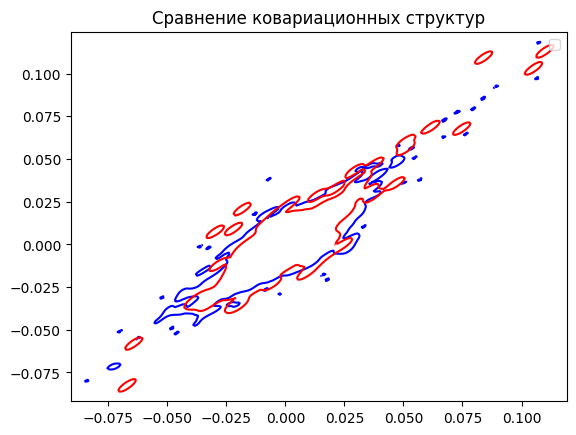

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Доверительные эллипсы для train и test
sns.kdeplot(x=XY_train[:, 0], y=XY_train[:, 1], levels=[0.01], color="blue", label="Train")
sns.kdeplot(x=XY_test[:, 0], y=XY_test[:, 1], levels=[0.01], color="red", label="Test")
plt.legend()
plt.title("Сравнение ковариационных структур")
plt.show()